# Kaggle "Predict Future Sales" Competition
### 1. Problem Definition:
- Goal: Predict total sales for every product and store in the following month.

### 2. Data Exploration:

In [61]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import sklearn as skl
from IPython.display import Markdown
from sklearn.preprocessing import OrdinalEncoder
import re
from itertools import product
from sklearn.metrics import mean_squared_error, mean_squared_log_error





In [7]:
#Read Data Sets
path = 'Dataset/'

DataDescription = Markdown(f"[Dataset Description]({path}DatasetDescription)")
display("This is Dataset Description, provided by Kaggle")
display(DataDescription)

item_cat_df  = pd.read_csv(path + 'item_categories.csv')
items_df           = pd.read_csv(path + 'items.csv')
raw_df       = pd.read_csv(path + 'sales_train.csv')
raw_df['date'] = pd.to_datetime(raw_df['date'], format="%d.%m.%Y")
sub_df = pd.read_csv(path + 'sample_submission.csv')
shops_df          = pd.read_csv(path + 'shops.csv')
test_df = pd.read_csv(path + 'test.csv')


'This is Dataset Description, provided by Kaggle'

[Dataset Description](Dataset/DatasetDescription)

Let's first have a look at the data sets:

In [12]:
display(itemCategories.head())
display(items.head())
display(salesTrain.head())
display(shops.head())

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


We will examine salesTrain Dataset.

Starting with date_block_num column to see if there are any possible missing values. 

In [24]:
# Getting value count from date_block_num coulmn and converting it into a Dataframe
date_block_num_valueCount = salesTrain['date_block_num'].value_counts().reset_index()

# Rename columns for clarity
date_block_num_valueCount.columns = ['Value', 'Count']

# Display DataFrame without index column
display(date_block_num_valueCount.style.hide(axis = 'index'))

Value,Count
11,143246
23,130786
2,121347
0,115690
1,108613
7,104772
6,100548
5,100403
12,99349
10,96736


In [8]:
import plotly.express as px

df_plot = raw_df.copy()
df_plot = df_plot[['date','item_cnt_day']].groupby(['date']).sum().reset_index()
df_plot['month'] = df_plot['date'].dt.to_period('M').apply(lambda r: r.start_time)
df_plot['month_num'] = df_plot['month'].rank(method="dense").astype(int)
df_plot

,date,item_cnt_day,month,month_num
0,2013-01-01,1951.0,2013-01-01,1
1,2013-01-02,8198.0,2013-01-01,1
2,2013-01-03,7422.0,2013-01-01,1
3,2013-01-04,6617.0,2013-01-01,1
4,2013-01-05,6346.0,2013-01-01,1
...,...,...,...,...
1029,2015-10-27,1551.0,2015-10-01,34
1030,2015-10-28,3593.0,2015-10-01,34
1031,2015-10-29,1589.0,2015-10-01,34
1032,2015-10-30,2274.0,2015-10-01,34


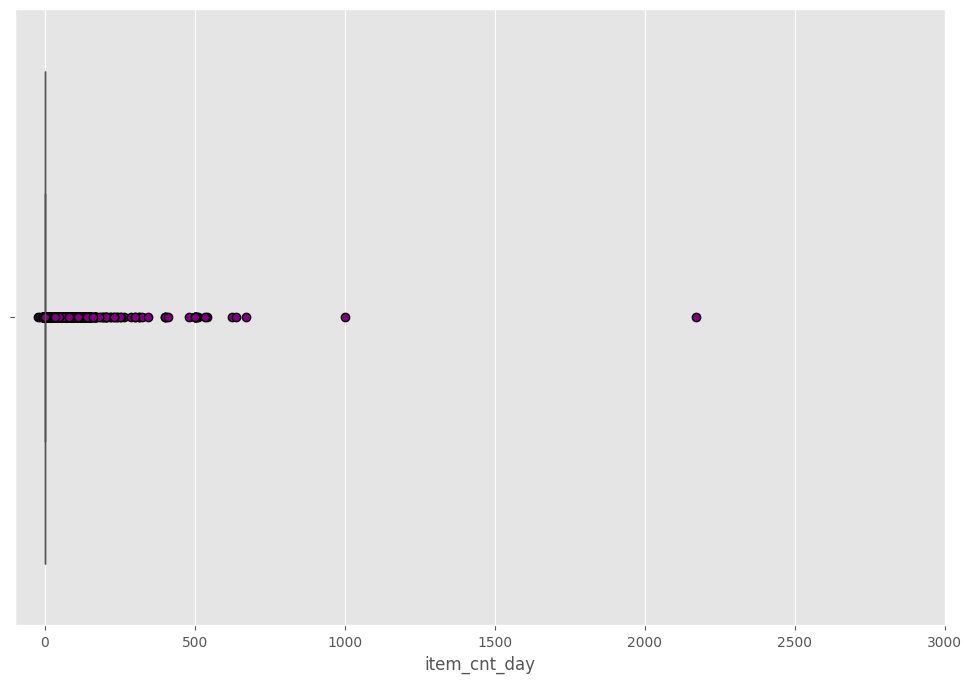

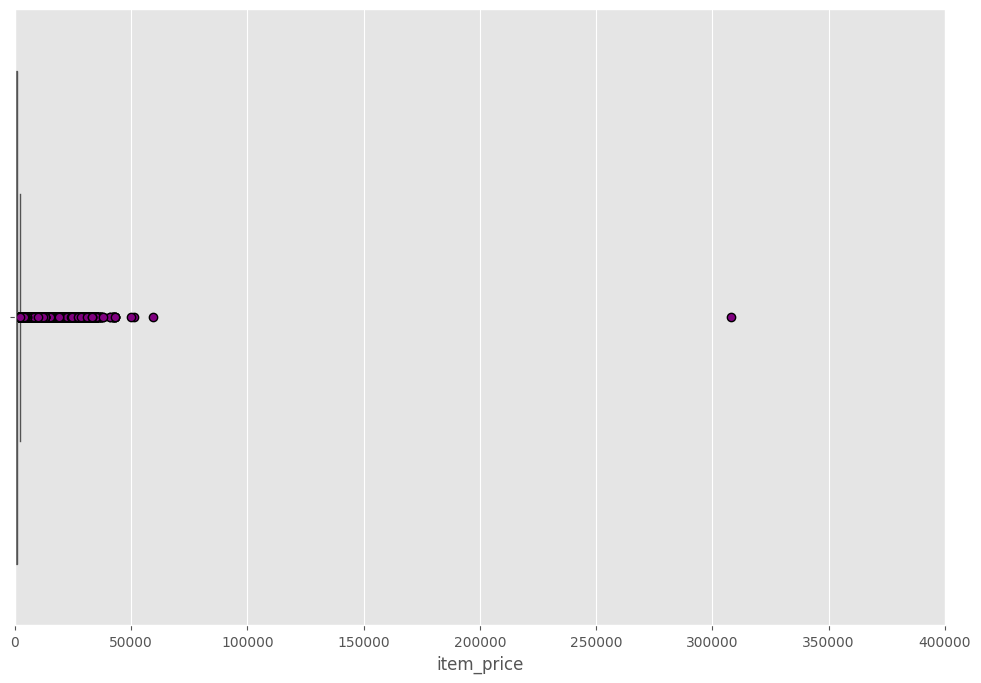

In [9]:
plt.figure(figsize=(12,8))
plt.xlim(-100,3000) ## tạo 1 đồ thì có 1 trục x
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black') # các điểm trên đồ thị biểu diễn bởi 'o' màu tím
sns.boxplot(x=raw_df['item_cnt_day'], flierprops=flierprops)
# => đồ thị biểu diễn phân bố sản phầm bán đc trong 1 ngày 

plt.figure(figsize=(12,8))
plt.xlim(-50,4e5)
sns.boxplot(x=raw_df['item_price'], flierprops=flierprops);
# => đồ thị biểu diễn phân bố giá

In [10]:
# lọc bỏ các giá trị bất thường giá trị quá cao hoặc quá thấp
raw_df[(raw_df['item_price']<300000)&(raw_df['item_cnt_day']<1000)].count()
raw_df[(raw_df['item_price']>300000)|(raw_df['item_cnt_day']>1000)].count()
raw_df = raw_df[(raw_df['item_price']<300000)&(raw_df['item_cnt_day']<1000)]

# Cleaning shops datas

In [11]:
shops_df['shop_city'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[0]) # cắt thành phố và địa tên ra riêng
shops_df['shop_category'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[1]) 
# And simple a city
shops_df['shop_city'] = shops_df['shop_city'].apply(lambda x: 'Якутск' if x=='!Якутск' else x)
shops_df

,shop_name,shop_id,shop_city,shop_category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,"(Плехановская,"
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,Торговля


In [12]:
shop_cats = shops_df['shop_category'].value_counts()
shop_cats = shop_cats[shop_cats>=5]
shop_cats_idx = shop_cats.index.tolist()
shops_df['shop_category'] = shops_df['shop_category'].apply(lambda x: x if x in shop_cats_idx else 'rem')

In [15]:
encoder = OrdinalEncoder()
shops_df[['shop_city','shop_category']] = encoder.fit_transform(shops_df[['shop_city','shop_category']])

In [16]:
shops_df = shops_df[['shop_id','shop_city','shop_category']]
shops_df

,shop_id,shop_city,shop_category
0,0,29.0,0.0
1,1,29.0,4.0
2,2,0.0,4.0
3,3,1.0,2.0
4,4,2.0,4.0
5,5,3.0,3.0
6,6,4.0,0.0
7,7,4.0,3.0
8,8,4.0,3.0
9,9,5.0,0.0


# cleaning item datas

In [17]:
items_df


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [18]:
def correct_item(x): ## làm sạch và xử lí đồng bộ các loại mặt hàng
    x = x.lower() # LowerCase
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub(r'[^A-Za-z0-9А-Яа-я]+',' ',x) # remove special char
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [26]:
#Tách phần tên gốc tiếng anh, nền tảng, và tên tiếng Nga riêng
items_df['item_name1'] = items_df['item_name'].apply(lambda x: re.split(r'[\[\(]',x,1)[0])
items_df['item_name2'] = items_df['item_name'].apply(lambda x: str(x).split('[',1)[1] if str(x).find('[')>=0 else '0')
items_df['item_name3'] = items_df['item_name'].apply(lambda x: str(x).split('(',1)[1] if str(x).find('(')>=0 else '0')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_33236\3806992381.py:2: DeprecationWarning: 'maxsplit' is passed as positional argument
  items_df['item_name1'] = items_df['item_name'].apply(lambda x: re.split(r'[\[\(]',x,1)[0])


In [27]:
#chuẩn hóa 3 cột item
for i in [1,2,3]:
    col = f'item_name{i}'
    items_df[col] = items_df[col].apply(lambda x: correct_item(str(x)))

In [28]:
items_df['item_name2'] = items_df['item_name2'].apply(lambda x: '0' if x=='' else x) # nếu itemname2 là rỗng thì chuyển thành 0

In [29]:
items_df['item_type'] = items_df['item_name2'].apply(lambda x: x[0:8]
                                                     if x.split(' ')[0]=='xbox'
                                                     else x.split(' ')[0]) 
items_df['item_type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', 'p', 'mac', 'psp',
       'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360', 'русская', 'рс',
       'android', 'англ', 'ps2', 'только', 'цифров', '6jv', 'j72', 'hm3',
       's3v', '6dv', '6l6', '5f4', 's4v', 'kg4', '5c5', '5c7', 'kf7',
       'kf6'], dtype=object)

In [30]:
def clean_item_type(x):
    if x=='xbox 360' or x=='x360' or x=='xbox360':
        return 'x360'
    if x=='pc' or x=='pс' or x=='рс':
        return 'pc'
    if x=='ps3' or x=='рs3':
        return 'ps3'
    return x
items_df['item_type'] = items_df['item_type'].apply(lambda x: clean_item_type(x))

In [31]:
item_types = items_df['item_type'].value_counts()
item_types = item_types[item_types>=20]
item_types_idx = item_types.index.tolist()
items_df['item_type'] = items_df['item_type'].apply(lambda x: x if x in item_types_idx else 'rem')

In [32]:
## chuyển từ chuỗi thành dạng categorical 
encoder = OrdinalEncoder()
items_df[['item_name2','item_name3','item_type']] = encoder.fit_transform(items_df[['item_name2','item_name3','item_type']])

In [33]:
items_df

,item_name,item_id,item_category_id,item_name1,item_name2,item_name3,item_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения,0.0,1083.0,0.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full,59.0,1.0,2.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы,0.0,795.0,0.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна,0.0,794.0,0.0
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка,0.0,1285.0,0.0
...,...,...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,ядерный титбит 2,59.0,1.0,2.0
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,язык запросов 1с предприятия,139.0,1.0,10.0
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,язык запросов 1с предприятия 8,0.0,461.0,0.0
22168,Яйцо для Little Inu,22168,62,яйцо для little inu,0.0,1.0,0.0


In [34]:
items_df = items_df[['item_id','item_category_id','item_name2','item_name3','item_type']]
items_df

,item_id,item_category_id,item_name2,item_name3,item_type
0,0,40,0.0,1083.0,0.0
1,1,76,59.0,1.0,2.0
2,2,40,0.0,795.0,0.0
3,3,40,0.0,794.0,0.0
4,4,40,0.0,1285.0,0.0
...,...,...,...,...,...
22165,22165,31,59.0,1.0,2.0
22166,22166,54,139.0,1.0,10.0
22167,22167,49,0.0,461.0,0.0
22168,22168,62,0.0,1.0,0.0


# Cleaning item cat datas

In [35]:
item_cat_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [36]:
item_cat_df['item_category_type'] = item_cat_df['item_category_name'].apply(lambda x: str(x).split(' ')[0])  # lấy loại sản phẩm 
item_cat_df['item_category_type'] = item_cat_df['item_category_type'].apply(lambda x: 'Игры' 
                                                                            if (x=='Игровые') or (x=='Аксессуары') 
                                                                            else x)

In [37]:
# làm tương tự như bên cửa hàng
item_cat_types = item_cat_df['item_category_type'].value_counts()
item_cat_types = item_cat_types[item_cat_types>=5]
item_cat_types_idx = item_cat_types.index.tolist()
item_cat_df['item_category_type'] = item_cat_df['item_category_type'].apply(lambda x: x if x in item_cat_types_idx else 'rem')

In [38]:
item_cat_df['split_sub'] = item_cat_df['item_category_name'].apply(lambda x: str(x).split('-'))
item_cat_df['item_category_sub_type'] = item_cat_df['split_sub'].apply(lambda x: x[1].strip() if len(x)>1 else x[0].strip())

In [39]:
encoder = OrdinalEncoder()
item_cat_df[['item_category_type','item_category_sub_type']] = encoder.fit_transform(item_cat_df[['item_category_type','item_category_sub_type']])

In [40]:
item_cat_df = item_cat_df[['item_category_id','item_category_type','item_category_sub_type']]
item_cat_df

,item_category_id,item_category_type,item_category_sub_type
0,0,0.0,29.0
1,1,1.0,9.0
2,2,1.0,10.0
3,3,1.0,11.0
4,4,1.0,13.0
...,...,...,...
79,79,0.0,54.0
80,80,0.0,25.0
81,81,0.0,62.0
82,82,0.0,63.0


# Data pre-processing and feature engineering

In [41]:
raw_df['revenue'] = raw_df['item_cnt_day'] * raw_df['item_price']

In [42]:
cols = ['date_block_num','shop_id','item_id']

In [45]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = raw_df[raw_df['date_block_num']==i]
    matrix.append(np.array(list(product([i],sales['shop_id'].unique(),sales['item_id'].unique())), dtype=np.int16))

matrix_df = pd.DataFrame(data=np.vstack(matrix), columns=cols)
matrix_df["date_block_num"] = matrix_df["date_block_num"].astype('int8')
matrix_df["shop_id"] = matrix_df["shop_id"].astype('int8')
matrix_df["item_id"] = matrix_df["item_id"].astype('int16')
matrix_df.sort_values(cols, inplace=True)

In [46]:
group = raw_df.groupby(cols)['item_cnt_day'].aggregate(['sum'])
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group
## tạo cái bảng dưới @@
matrix_df = matrix_df.reset_index(drop=True)
matrix_df = pd.merge(matrix_df, group, on=cols, how='left')
matrix_df.fillna({'item_cnt_month':0},inplace=True)
matrix_df['item_cnt_month'] = matrix_df['item_cnt_month'].astype('float16')

In [47]:
test_df['date_block_num'] = 34 ## chỉnh tháng của các sản phẩm cần dự đoán là 34
test_df['date_block_num'] = test_df['date_block_num'].astype('int8')
test_df['shop_id'] = test_df['shop_id'].astype('int8')
test_df['item_id'] = test_df['item_id'].astype('int16')
## chỉnh kiểu dữ liệu 
# test_df.drop(columns='ID',inplace=True) đã drop rồi nên không có nữa
test_df

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [48]:
concat_df = pd.concat([matrix_df,test_df]).copy()
concat_df = concat_df.reset_index(drop=True)
concat_df.fillna({'item_cnt_month':0},inplace=True)
concat_df

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,NaN
1,0,0,27,0.0,NaN
2,0,0,28,0.0,NaN
3,0,0,29,0.0,NaN
4,0,0,32,6.0,NaN
...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0
11128000,34,45,16188,0.0,214196.0
11128001,34,45,15757,0.0,214197.0
11128002,34,45,19648,0.0,214198.0


In [49]:
concat_df = pd.merge(concat_df, items_df, on='item_id', how='left')
concat_df = pd.merge(concat_df, item_cat_df, on='item_category_id', how='left')
concat_df = pd.merge(concat_df, shops_df, on='shop_id', how='left')
concat_df

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,item_name2,item_name3,item_type,item_category_type,item_category_sub_type,shop_city,shop_category
0,0,0,19,0.0,NaN,40,0.0,1.0,0.0,3.0,4.0,29.0,0.0
1,0,0,27,0.0,NaN,19,72.0,1.0,4.0,1.0,10.0,29.0,0.0
2,0,0,28,0.0,NaN,30,102.0,1.0,2.0,1.0,55.0,29.0,0.0
3,0,0,29,0.0,NaN,23,117.0,1.0,8.0,1.0,16.0,29.0,0.0
4,0,0,32,6.0,NaN,40,0.0,1.0,0.0,3.0,4.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,55,0.0,1.0,0.0,5.0,2.0,20.0,4.0
11128000,34,45,16188,0.0,214196.0,64,0.0,1.0,0.0,6.0,42.0,20.0,4.0
11128001,34,45,15757,0.0,214197.0,55,0.0,1.0,0.0,5.0,2.0,20.0,4.0
11128002,34,45,19648,0.0,214198.0,40,0.0,1118.0,0.0,3.0,4.0,20.0,4.0


In [50]:
concat_df.columns


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_category_id', 'item_name2', 'item_name3', 'item_type',
       'item_category_type', 'item_category_sub_type', 'shop_city',
       'shop_category'],
      dtype='object')

### 4. Model Selection:

In [51]:
concat_df.drop(columns=['ID'], inplace=True)


In [52]:
def create_lag_feature(df, lags, features):
    for feature in features:
        print(feature)
        for lag in lags:
            shifted = df[['date_block_num','shop_id','item_id',feature]].copy()
            shifted.columns = ['date_block_num','shop_id','item_id',f'{feature}_lag_{lag}']
            shifted['date_block_num'] = shifted['date_block_num'] + lag
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
    
lag_for_ml = [i+1 for i in range(3)]
concat_df = create_lag_feature(concat_df, lags=lag_for_ml, features=['item_cnt_month'])

item_cnt_month


In [53]:
train_inputs = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>3)]
train_targets = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>3)]['item_cnt_month']

val_inputs = concat_df[concat_df['date_block_num']==33]
val_targets = concat_df[concat_df['date_block_num']==33]['item_cnt_month']

test_inputs = concat_df[concat_df['date_block_num']==34]

In [54]:
train_targets = train_targets.clip(0,20)
val_targets = val_targets.clip(0,20)

In [83]:
xgb_param =  {'colsample_bytree': 0.8406368905921987, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.023622088178310074, 'max_bin': 256, 'max_depth': 10, 'min_child_weight': 1.9311905509233425, 'n_estimators': 700, 'nthread': 2, 'reg_lambda': 0.004641439538226732, 'subsample': 0.8055867639368266, 'tree_method': 'hist'}

In [84]:
import xgboost as xgb
from xgboost import XGBRegressor 

In [85]:
xgb_param['objective'] = 'reg:squarederror'  # Hoặc 'reg:absoluteerror'
model = xgb.XGBRegressor(**xgb_param)

In [86]:
eval_set = (val_inputs, val_targets)
model.fit(train_inputs, train_targets, eval_set=[eval_set], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8406368905921987, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.023622088178310074,
             max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1.9311905509233425, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, nthread=2, ...)

In [87]:
train_preds = model.predict(train_inputs)
val_preds = model.predict(val_inputs) 
train_score = np.sqrt(mean_squared_error(train_targets, train_preds))
val_score = np.sqrt(mean_squared_error(val_targets, val_preds))

In [88]:
train_score, val_score


(np.float64(0.18046168771772217), np.float64(0.23559786938872115))